## **Experimenting With Using XGBoost**

In [ ]:
!pip install numpy pandas matplotlib seaborn --quiet

In [ ]:
!pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 62.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
fitbit_data = pd.read_csv('/content/drive/My Drive/colab_data/data_daily_w_visits.csv')

Preprocessing Data

In [ ]:
# Ensure date is datetime and sort
fitbit_data['date'] = pd.to_datetime(fitbit_data['date'])
fitbit_data = fitbit_data.sort_values(by=['fitbit_user_id', 'date'])

In [ ]:
# Organizing columns
measure_cols = ['avgWeight_per_day', 'calories', 'heart', 'steps']
survey_cols = ['diet', 'medication', 'symptoms']
result_col = 'visit_day'

In [ ]:
fitbit_data[result_col] = fitbit_data[result_col].fillna(0)

In [ ]:
def fix_survey_cols(df, cols):
    df = df.copy()

    # Sort by user and date to ensure proper shifting
    df = df.sort_values(by=['fitbit_user_id', 'date'])

    # Shift survey columns backward by one day within each user group
    for col in cols:
        df[f'{col}_cur'] = df.groupby('fitbit_user_id')[col].shift(-1)

    return df

fitbit_data = fix_survey_cols(fitbit_data, survey_cols)

In [ ]:
fitbit_data

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,diet,medication,symptoms,minutes_asleep,minutes_awake,days,admit_type,death,visit_day,diet_cur,medication_cur,symptoms_cur
0,0,2021-07-27,App Money,1,228.619094,2879.0,66.0,6260.0,2.0,2.0,1.0,NaN,NaN,0,NaN,NaN,0.0,1.0,2.0,1.0
1,1,2021-07-28,App Money,1,227.560876,3207.0,66.0,10805.0,1.0,2.0,1.0,270.0,46.0,1,NaN,NaN,0.0,1.0,2.0,0.0
2,2,2021-07-29,App Money,1,227.186091,2911.0,67.0,8292.0,1.0,2.0,0.0,141.0,23.0,2,NaN,NaN,0.0,2.0,2.0,0.0
3,3,2021-07-30,App Money,1,225.973550,3301.0,66.0,8250.0,2.0,2.0,0.0,172.0,53.0,3,NaN,NaN,0.0,2.0,2.0,0.0
4,4,2021-07-31,App Money,1,225.459139,3106.0,66.0,7704.0,2.0,2.0,0.0,99.0,5.0,4,NaN,NaN,0.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44815,44815,2025-03-12,No App,307,NaN,2244.0,64.0,3297.0,NaN,NaN,NaN,NaN,NaN,175,NaN,NaN,0.0,NaN,NaN,NaN
44816,44816,2025-03-13,No App,307,NaN,2152.0,63.0,3730.0,NaN,NaN,NaN,NaN,NaN,176,NaN,NaN,0.0,NaN,NaN,NaN
44817,44817,2025-03-14,No App,307,NaN,2529.0,64.0,6657.0,NaN,NaN,NaN,NaN,NaN,177,NaN,NaN,0.0,NaN,NaN,NaN
44818,44818,2025-03-15,No App,307,NaN,2494.0,64.0,7626.0,NaN,NaN,NaN,NaN,NaN,178,NaN,NaN,0.0,NaN,NaN,NaN


In [ ]:
import numpy as np
import pandas as pd

def one_hot_encode_with_nan(df, cols):
    df = df.copy()
    for col in cols:
        dummies = pd.get_dummies(df[col], prefix=col)

        # Set dummy rows to np.nan where original was NaN
        dummies[df[col].isna()] = np.nan

        # Convert dummies to float so XGBoost can handle them
        dummies = dummies.astype(float)

        df = pd.concat([df, dummies], axis=1)
        df.drop(columns=[col], inplace=True)
    return df

fb_data = one_hot_encode_with_nan(fitbit_data, survey_cols)

/tmp/ipython-input-48-3585094128.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dummies[df[col].isna()] = np.nan
/tmp/ipython-input-48-3585094128.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dummies[df[col].isna()] = np.nan
/tmp/ipython-input-48-3585094128.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dummies[df[col].isna()] = np.nan
/tmp/ipython-input-48-3585094128.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will

In [ ]:
fb_data

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,minutes_asleep,minutes_awake,...,symptoms_cur,diet_0.0,diet_1.0,diet_2.0,medication_0.0,medication_1.0,medication_2.0,symptoms_0.0,symptoms_1.0,symptoms_2.0
0,0,2021-07-27,App Money,1,228.619094,2879.0,66.0,6260.0,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,2021-07-28,App Money,1,227.560876,3207.0,66.0,10805.0,270.0,46.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,2,2021-07-29,App Money,1,227.186091,2911.0,67.0,8292.0,141.0,23.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,3,2021-07-30,App Money,1,225.973550,3301.0,66.0,8250.0,172.0,53.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,4,2021-07-31,App Money,1,225.459139,3106.0,66.0,7704.0,99.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44815,44815,2025-03-12,No App,307,NaN,2244.0,64.0,3297.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44816,44816,2025-03-13,No App,307,NaN,2152.0,63.0,3730.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44817,44817,2025-03-14,No App,307,NaN,2529.0,64.0,6657.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44818,44818,2025-03-15,No App,307,NaN,2494.0,64.0,7626.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(fb_data[measure_cols])
fb_data[measure_cols] = scaler.transform(fb_data[measure_cols])

In [ ]:
fb_data

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,minutes_asleep,minutes_awake,...,symptoms_cur,diet_0.0,diet_1.0,diet_2.0,medication_0.0,medication_1.0,medication_2.0,symptoms_0.0,symptoms_1.0,symptoms_2.0
0,0,2021-07-27,App Money,1,0.533696,0.198254,0.365854,0.169098,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,2021-07-28,App Money,1,0.530795,0.223150,0.365854,0.291869,270.0,46.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,2,2021-07-29,App Money,1,0.529767,0.200683,0.378049,0.223987,141.0,23.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,3,2021-07-30,App Money,1,0.526443,0.230285,0.365854,0.222853,172.0,53.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,4,2021-07-31,App Money,1,0.525033,0.215484,0.365854,0.208104,99.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44815,44815,2025-03-12,No App,307,NaN,0.150057,0.341463,0.089060,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44816,44816,2025-03-13,No App,307,NaN,0.143074,0.329268,0.100756,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44817,44817,2025-03-14,No App,307,NaN,0.171689,0.341463,0.179822,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44818,44818,2025-03-15,No App,307,NaN,0.169032,0.341463,0.205997,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=fb_data)

https://docs.google.com/spreadsheets/d/1oRrd88xBnZmZ7fGmgvWUJleNuPjNEVB5noM6Mis5XvU/edit#gid=0


In [ ]:
oneh_cols = ['diet_0.0', 'diet_1.0', 'diet_2.0', 'medication_0.0', 'medication_1.0', 'medication_2.0', 'symptoms_0.0', 'symptoms_1.0', 'symptoms_2.0']

In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Get unique user IDs
unique_users = fb_data['fitbit_user_id'].unique()

# Step 2: Split user IDs into train/test
train, test = train_test_split(
    unique_users, test_size=0.2, random_state=42
)

# Step 3: Filter original DataFrame based on user ID
train_df = fb_data[fb_data['fitbit_user_id'].isin(train)].reset_index(drop=True)
test_df = fb_data[fb_data['fitbit_user_id'].isin(test)].reset_index(drop=True)

In [ ]:
train_df

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,minutes_asleep,minutes_awake,...,symptoms_cur,diet_0.0,diet_1.0,diet_2.0,medication_0.0,medication_1.0,medication_2.0,symptoms_0.0,symptoms_1.0,symptoms_2.0
0,0,2021-07-27,App Money,1,0.533696,0.198254,0.365854,0.169098,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,2021-07-28,App Money,1,0.530795,0.223150,0.365854,0.291869,270.0,46.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,2,2021-07-29,App Money,1,0.529767,0.200683,0.378049,0.223987,141.0,23.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,3,2021-07-30,App Money,1,0.526443,0.230285,0.365854,0.222853,172.0,53.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,4,2021-07-31,App Money,1,0.525033,0.215484,0.365854,0.208104,99.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35815,44815,2025-03-12,No App,307,NaN,0.150057,0.341463,0.089060,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35816,44816,2025-03-13,No App,307,NaN,0.143074,0.329268,0.100756,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35817,44817,2025-03-14,No App,307,NaN,0.171689,0.341463,0.179822,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35818,44818,2025-03-15,No App,307,NaN,0.169032,0.341463,0.205997,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
test_df

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,minutes_asleep,minutes_awake,...,symptoms_cur,diet_0.0,diet_1.0,diet_2.0,medication_0.0,medication_1.0,medication_2.0,symptoms_0.0,symptoms_1.0,symptoms_2.0
0,1080,2021-08-12,No App,8,NaN,0.111044,0.231707,0.032604,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1081,2021-08-13,No App,8,NaN,0.116812,0.231707,0.034981,713.0,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1082,2021-08-14,No App,8,NaN,0.123719,0.231707,0.054673,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1083,2021-08-15,No App,8,NaN,0.112562,0.219512,0.017153,694.0,114.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1084,2021-08-16,No App,8,0.427924,0.143757,0.231707,0.084063,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,44455,2025-01-29,App Money,304,NaN,0.171917,0.231707,0.147974,335.0,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8996,44456,2025-01-30,App Money,304,NaN,0.184896,0.219512,0.176715,382.0,57.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8997,44457,2025-01-31,App Money,304,NaN,0.187628,0.195122,0.169746,451.0,61.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8998,44458,2025-02-01,App Money,304,NaN,0.195901,0.207317,0.216721,415.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
x_measure = train_df[measure_cols]
x_survey = train_df[oneh_cols]
y = train_df[result_col]

x_measure_test = test_df[measure_cols]
x_survey_test = test_df[oneh_cols]
y_test = test_df[result_col]

x_combined = pd.concat([x_measure, x_survey], axis=1)
x_combined_test = pd.concat([x_measure_test, x_survey_test], axis=1)

y = y.astype(int)
y_test = y_test.astype(int)

In [ ]:
print(y_test.value_counts())

visit_day
0.0    8991
1.0       9
Name: count, dtype: int64


In [ ]:
measure_cols+oneh_cols

['avgWeight_per_day',
 'calories',
 'heart',
 'steps',
 'diet_0.0',
 'diet_1.0',
 'diet_2.0',
 'medication_0.0',
 'medication_1.0',
 'medication_2.0',
 'symptoms_0.0',
 'symptoms_1.0',
 'symptoms_2.0']

# XGBoost Time

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_measure = XGBClassifier(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)
xgb_survey = XGBClassifier(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)
xgb_both = XGBClassifier(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

In [ ]:
print("Target balance:\n", y.value_counts())
print("Feature variances:\n", x_combined.nunique())
print("All-zero rows in X:", (x_combined == 0).all(axis=1).sum())
print("X shape:", x_combined.shape)
print("y shape:", y.shape)
print("Indexes aligned:", x_combined.index.equals(y.index))

Target balance:
 visit_day
0    35749
1       71
Name: count, dtype: int64
Feature variances:
 avgWeight_per_day     2522
calories              3219
heart                   78
steps                12099
diet_0.0                 2
diet_1.0                 2
diet_2.0                 2
medication_0.0           2
medication_1.0           2
medication_2.0           2
symptoms_0.0             2
symptoms_1.0             2
symptoms_2.0             2
dtype: int64
All-zero rows in X: 0
X shape: (35820, 13)
y shape: (35820,)
Indexes aligned: True


In [ ]:
xgb_measure.fit(x_measure.values, y.values)
xgb_survey.fit(x_survey.values, y.values)
xgb_both.fit(x_combined.values, y.values)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
x_measure

,avgWeight_per_day,calories,heart,steps
0,0.533696,0.198254,0.365854,0.169098
1,0.530795,0.223150,0.365854,0.291869
2,0.529767,0.200683,0.378049,0.223987
3,0.526443,0.230285,0.365854,0.222853
4,0.525033,0.215484,0.365854,0.208104
...,...,...,...,...
35815,NaN,0.150057,0.341463,0.089060
35816,NaN,0.143074,0.329268,0.100756
35817,NaN,0.171689,0.341463,0.179822
35818,NaN,0.169032,0.341463,0.205997


In [ ]:
x_survey

,diet_0.0,diet_1.0,diet_2.0,medication_0.0,medication_1.0,medication_2.0,symptoms_0.0,symptoms_1.0,symptoms_2.0
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
35815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
preds_measure = xgb_measure.predict(x_measure)
preds_survey = xgb_survey.predict(x_survey)
preds_both = xgb_both.predict(x_combined)

In [ ]:
preds_measure

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
preds_survey

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
preds_both

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

In [ ]:
rmse(preds_measure, y)

np.float64(0.044521151003264724)

In [ ]:
rmse(preds_survey, y)

np.float64(0.044521151003264724)

In [ ]:
rmse(preds_both, y)

np.float64(0.044521151003264724)

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 30,30

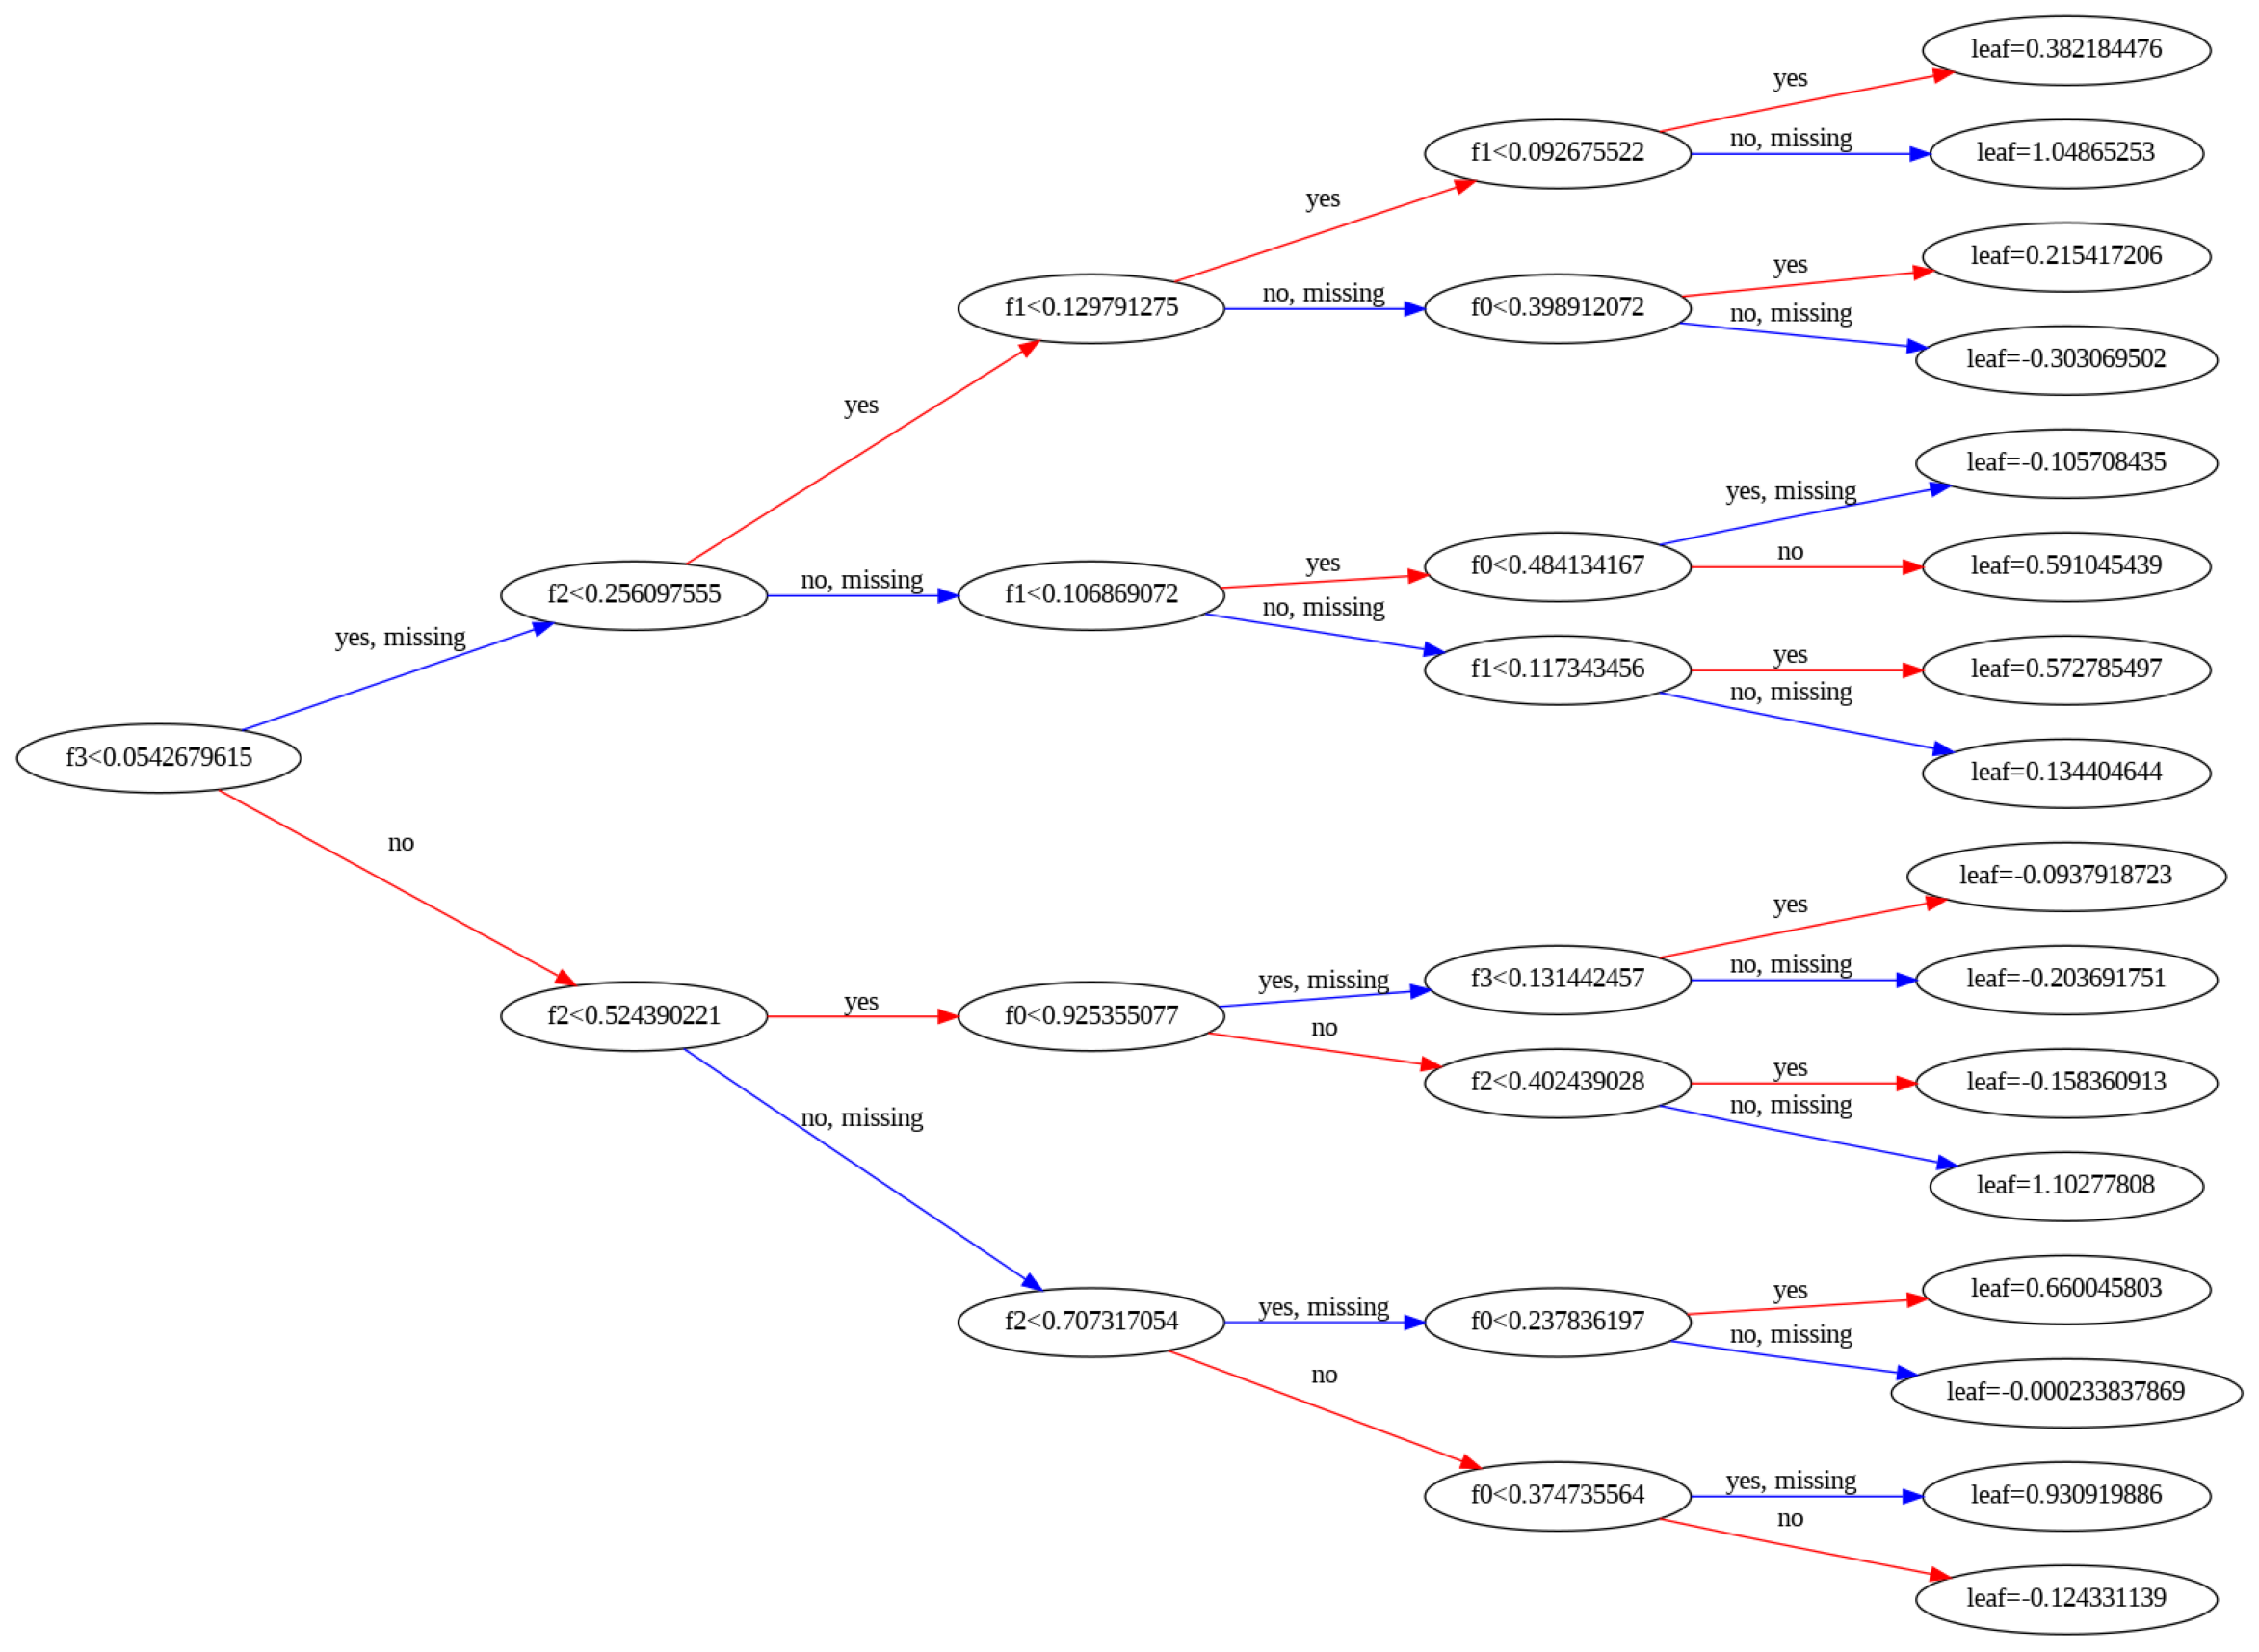

In [ ]:
plot_tree(xgb_measure, rankdir='LR');

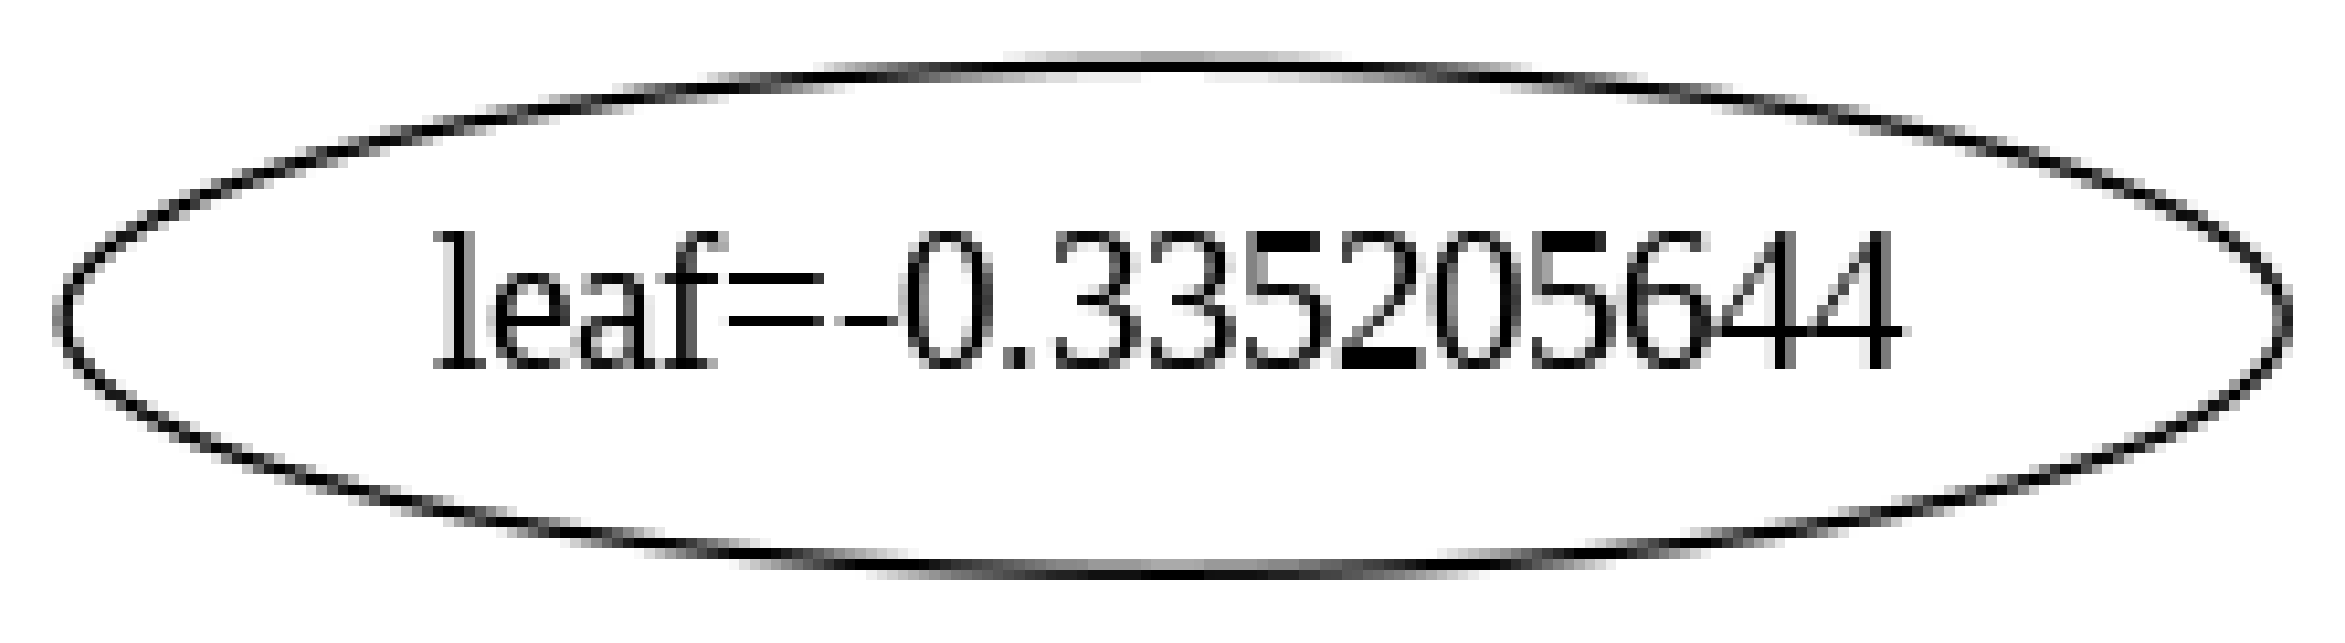

In [ ]:
plot_tree(xgb_survey, rankdir='LR');

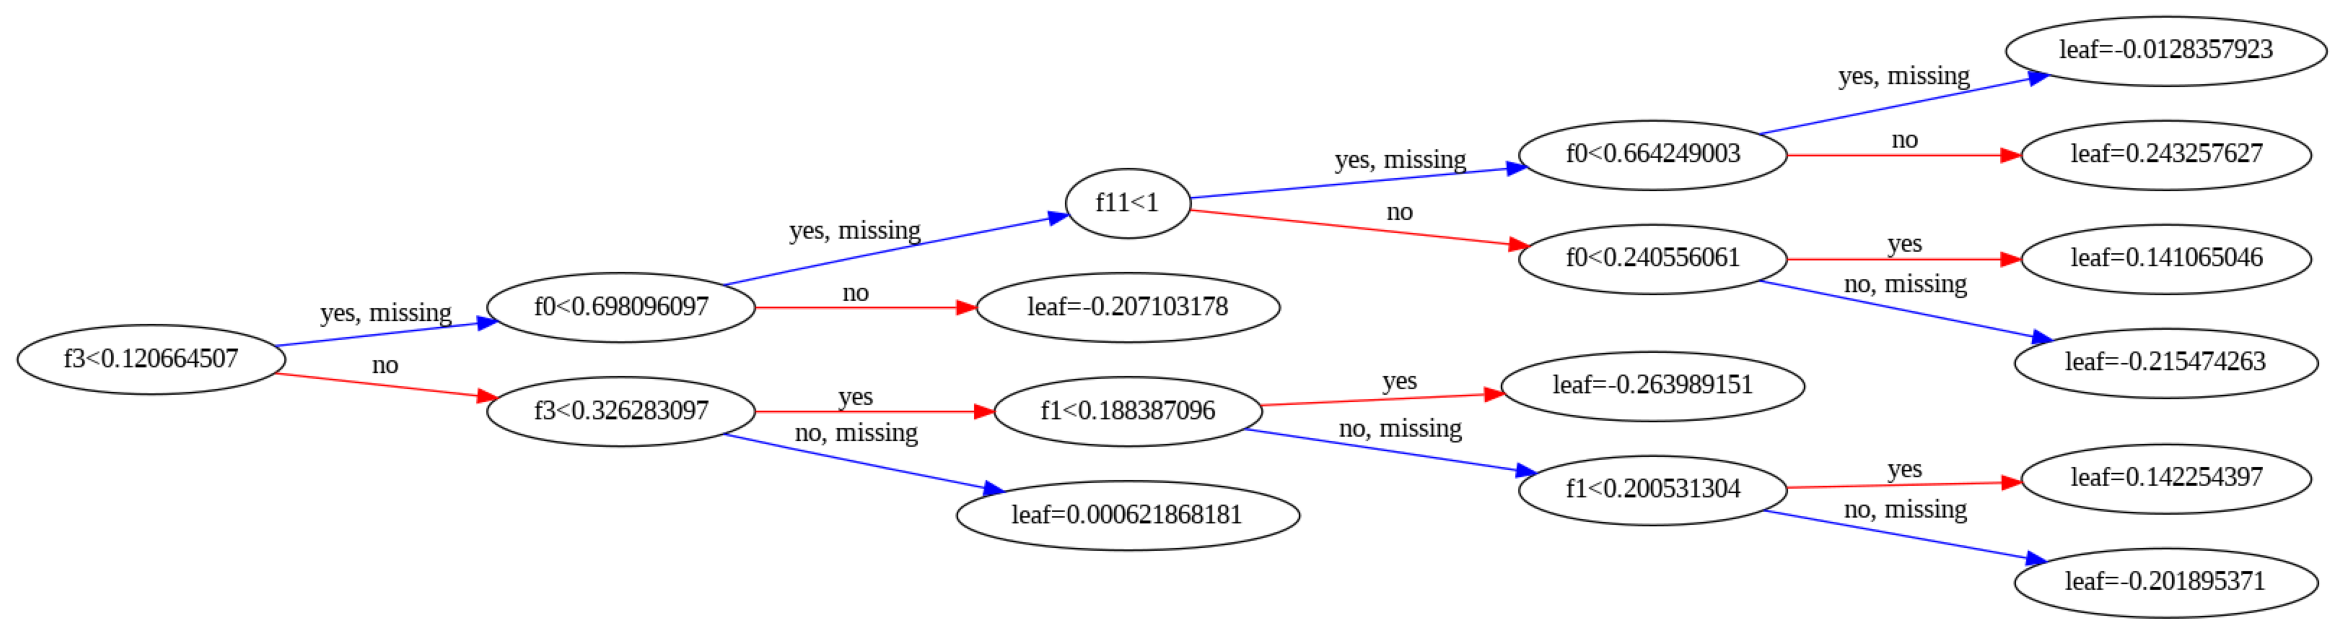

In [ ]:
plot_tree(xgb_both, rankdir='LR', num_trees=19);

In [ ]:
importance_df_m = pd.DataFrame({
    'feature': x_measure.columns,
    'importance': xgb_measure.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_df_m.head(10)

,feature,importance
3,steps,0.315612
1,calories,0.274542
2,heart,0.222351
0,avgWeight_per_day,0.187495


In [ ]:
importance_df_s = pd.DataFrame({
    'feature': x_survey.columns,
    'importance': xgb_survey.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_df_s.head(10)

,feature,importance
8,symptoms_2.0,0.744809
2,diet_2.0,0.162292
6,symptoms_0.0,0.024245
1,diet_1.0,0.021270
5,medication_2.0,0.016388
0,diet_0.0,0.015951
3,medication_0.0,0.013600
4,medication_1.0,0.001069
7,symptoms_1.0,0.000377


In [ ]:
importance_df_b = pd.DataFrame({
    'feature': x_combined.columns,
    'importance': xgb_both.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_df_b.head(10)

,feature,importance
12,symptoms_2.0,0.188322
3,steps,0.120870
1,calories,0.095802
10,symptoms_0.0,0.094281
2,heart,0.087797
0,avgWeight_per_day,0.077454
9,medication_2.0,0.070789
5,diet_1.0,0.064780
7,medication_0.0,0.062324
4,diet_0.0,0.038069


In [ ]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [ ]:
preds = predict_avg(models, X)

In [ ]:
preds

array([0., 0., 0., ..., 0., 0., 0.])

Final Model Work

In [ ]:
x_combined_test

,avgWeight_per_day,calories,heart,steps,diet_0.0,diet_1.0,diet_2.0,medication_0.0,medication_1.0,medication_2.0,symptoms_0.0,symptoms_1.0,symptoms_2.0
0,NaN,0.111044,0.231707,0.032604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.116812,0.231707,0.034981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0.123719,0.231707,0.054673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.112562,0.219512,0.017153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.427924,0.143757,0.231707,0.084063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,NaN,0.171917,0.231707,0.147974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8996,NaN,0.184896,0.219512,0.176715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8997,NaN,0.187628,0.195122,0.169746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8998,NaN,0.195901,0.207317,0.216721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Accuracy: 0.8213333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90      7740
           1       0.20      0.09      0.13      1260

    accuracy                           0.82      9000
   macro avg       0.53      0.52      0.51      9000
weighted avg       0.77      0.82      0.79      9000

AUC Score: 0.5409576104343545
Confusion Matrix:
 [[7273  467]
 [1141  119]]


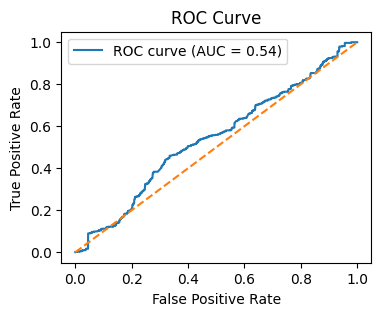

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# Measure + survey


# Predict class and probabilities
y_pred = xgb_both.predict(x_combined_test)
y_prob = xgb_both.predict_proba(x_combined_test)[:, 1]

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plot ROC Curve
plt.figure(figsize=(4, 3))
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label="ROC curve (AUC = {:.2f})".format(roc_auc_score(y_test, y_prob)))
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")
plt.show()


Accuracy: 0.8108888888888889
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      7740
           1       0.12      0.05      0.07      1260

    accuracy                           0.81      9000
   macro avg       0.49      0.49      0.48      9000
weighted avg       0.76      0.81      0.78      9000

AUC Score: 0.5051388376194578
Confusion Matrix:
 [[7229  511]
 [1191   69]]


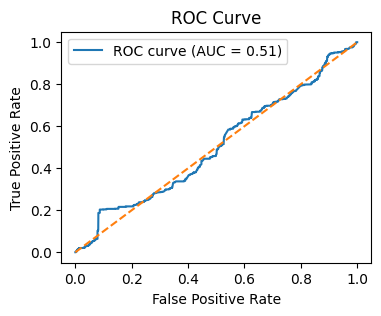

In [ ]:
# Measure


# Predict class and probabilities
y_pred = xgb_measure.predict(x_measure_test)
y_prob = xgb_measure.predict_proba(x_measure_test)[:, 1]

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plot ROC Curve
plt.figure(figsize=(4, 3))
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label="ROC curve (AUC = {:.2f})".format(roc_auc_score(y_test, y_prob)))
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")
plt.show()

Accuracy: 0.8622222222222222
Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.93      7740
           1       0.74      0.02      0.05      1260

    accuracy                           0.86      9000
   macro avg       0.80      0.51      0.49      9000
weighted avg       0.85      0.86      0.80      9000

AUC Score: 0.5339840962224683
Confusion Matrix:
 [[7729   11]
 [1229   31]]


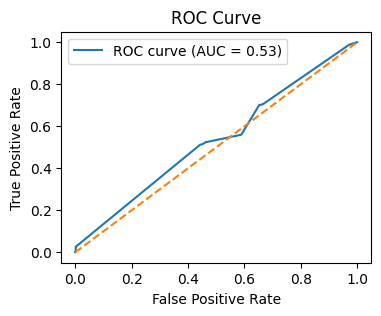

In [ ]:
# Survey


# Predict class and probabilities
y_pred = xgb_survey.predict(x_survey_test)
y_prob = xgb_survey.predict_proba(x_survey_test)[:, 1]

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plot ROC Curve
plt.figure(figsize=(4, 3))
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label="ROC curve (AUC = {:.2f})".format(roc_auc_score(y_test, y_prob)))
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")
plt.show()

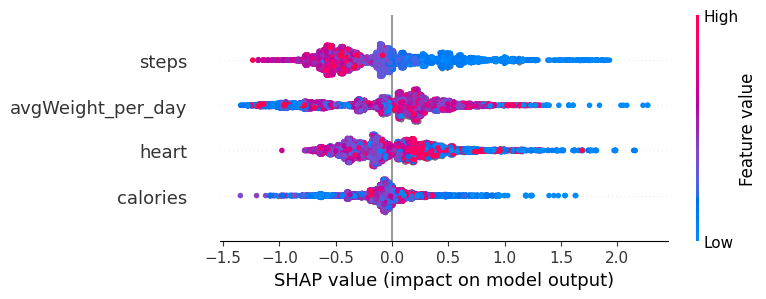

In [ ]:
import shap

explainer = shap.Explainer(xgb_measure)
shap_values = explainer(x_measure_test)

shap.summary_plot(shap_values, x_measure_test)

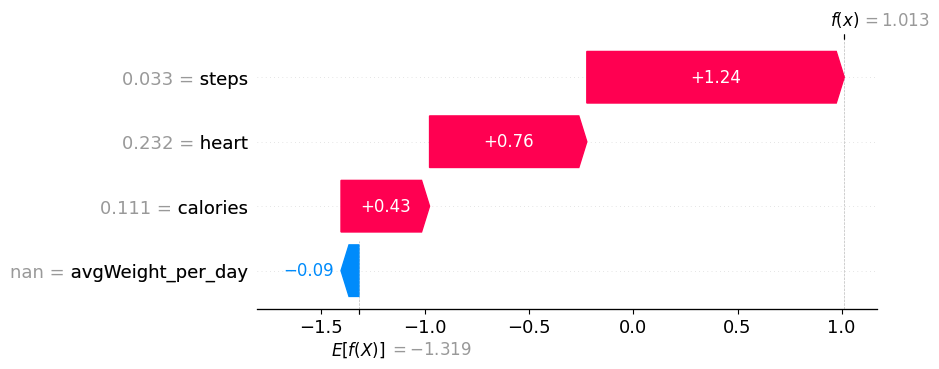

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.plots.initjs()
shap.plots.force(shap_values[0])

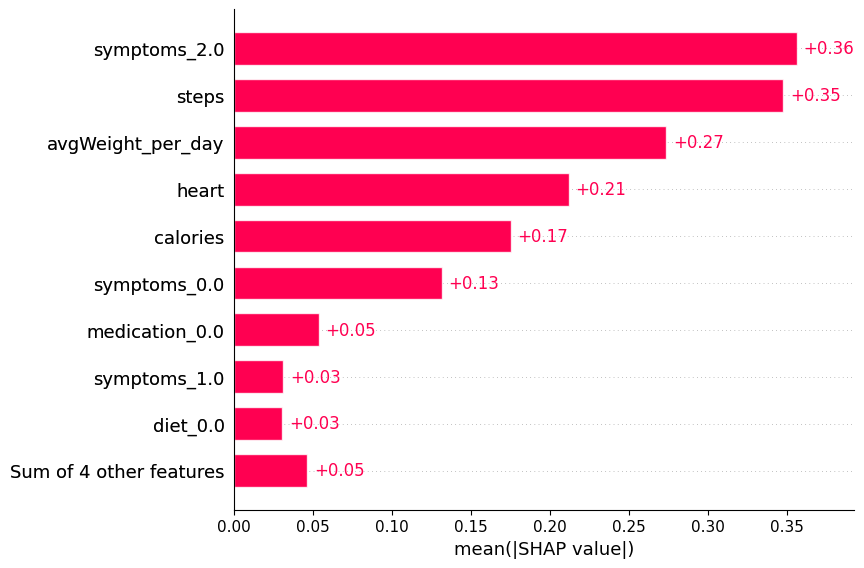

In [ ]:
shap.plots.bar(shap_values)

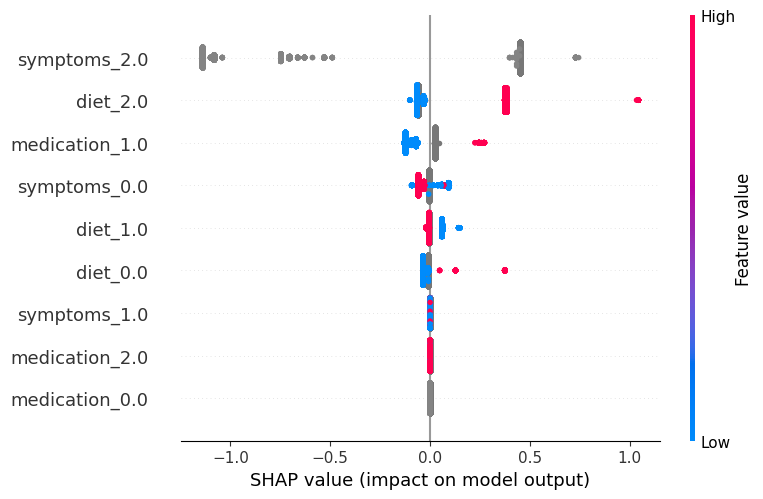

In [ ]:
explainer = shap.Explainer(xgb_survey)
shap_values = explainer(x_survey_test)

shap.summary_plot(shap_values, x_survey_test)

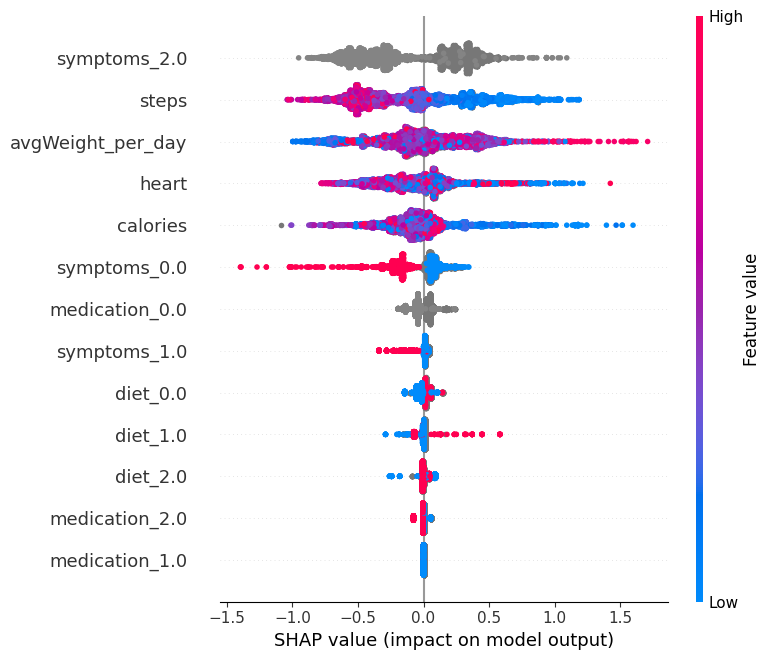

In [ ]:
explainer = shap.Explainer(xgb_both)
shap_values = explainer(x_combined_test)

shap.summary_plot(shap_values, x_combined_test)

# Hyperparameter Tuning + K Fold

In [ ]:
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
x = fb_data[measure_cols+oneh_cols+['fitbit_user_id']]
targets = fb_data[result_col].astype(int)


# Define GroupKFold with number of splits
gkf = GroupKFold(n_splits=10)
sgkf = StratifiedGroupKFold(n_splits=10)

groups = x['fitbit_user_id']  # or however you track user grouping

In [ ]:
def train_and_evaluate(X_train, y_train, X_val, y_val, **params):
    model = XGBClassifier(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, y_train)

    # get hard predictions
    y_pred_train = model.predict(X_train)
    y_pred_val   = model.predict(X_val)

    # compute accuracy instead of rmse
    train_acc = accuracy_score(y_train, y_pred_train)
    val_acc   = accuracy_score(y_val,   y_pred_val)

    return model, train_acc, val_acc

def train_and_evaluate_auc(X_train, y_train, X_val, y_val, **params):
    model = XGBClassifier(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, y_train)

    # get positive‐class probabilities
    p_tr = model.predict_proba(X_train)[:,1]
    p_vl = model.predict_proba(X_val)[:,1]

    train_auc = roc_auc_score(y_train, p_tr)
    val_auc   = roc_auc_score(y_val,   p_vl)

    return model, train_auc, val_auc

In [ ]:
modelsGK = []
for train_idx, val_idx in gkf.split(x, targets, groups=groups):
    X_tr, y_tr = x.iloc[train_idx], targets.iloc[train_idx]
    X_vl, y_vl = x.iloc[val_idx], targets.iloc[val_idx]

    model, train_acc, val_acc = train_and_evaluate(
        X_tr, y_tr,
        X_vl, y_vl,
        max_depth=4,
        n_estimators=20
    )

    model, train_auc, val_auc = train_and_evaluate_auc(
        X_tr, y_tr,
        X_vl, y_vl,
        max_depth=4,
        n_estimators=20
    )

    model.fit(X_tr, y_tr)
    y_pred_val = model.predict(X_vl)

    modelsGK.append(model)
    print(f"Train  Acc: {train_acc:.3f},  Validation Acc: {val_acc:.3f}")
    print(f"Train  AUC: {train_auc:.3f},  Validation AUC: {val_auc:.3f}")
    cm = confusion_matrix(y_vl, y_pred_val)
    print(f"Confusion Matrix:\n{cm}\n")

Train  Acc: 0.929,  Validation Acc: 0.739
Train  AUC: 0.981,  Validation AUC: 0.657
Confusion Matrix:
[[3079  341]
 [ 835  245]]

Train  Acc: 0.922,  Validation Acc: 0.752
Train  AUC: 0.981,  Validation AUC: 0.657
Confusion Matrix:
[[3353  247]
 [ 869   31]]

Train  Acc: 0.944,  Validation Acc: 0.750
Train  AUC: 0.991,  Validation AUC: 0.379
Confusion Matrix:
[[3372  228]
 [ 899    1]]

Train  Acc: 0.926,  Validation Acc: 0.683
Train  AUC: 0.975,  Validation AUC: 0.373
Confusion Matrix:
[[3074  526]
 [ 900    0]]

Train  Acc: 0.931,  Validation Acc: 0.739
Train  AUC: 0.988,  Validation AUC: 0.419
Confusion Matrix:
[[3327   93]
 [1080    0]]

Train  Acc: 0.929,  Validation Acc: 0.821
Train  AUC: 0.985,  Validation AUC: 0.263
Confusion Matrix:
[[3694  446]
 [ 360    0]]

Train  Acc: 0.941,  Validation Acc: 0.796
Train  AUC: 0.984,  Validation AUC: 0.631
Confusion Matrix:
[[3376  404]
 [ 515  205]]

Train  Acc: 0.918,  Validation Acc: 0.740
Train  AUC: 0.985,  Validation AUC: 0.521
Confus

In [ ]:
modelsSGK = []
for train_idx, val_idx in sgkf.split(x, targets, groups=groups):
    X_tr, y_tr = x.iloc[train_idx], targets.iloc[train_idx]
    X_vl, y_vl = x.iloc[val_idx], targets.iloc[val_idx]

    model, train_acc, val_acc = train_and_evaluate(
        X_tr, y_tr,
        X_vl, y_vl,
        max_depth=4,
        n_estimators=20
    )
    model, train_auc, val_auc = train_and_evaluate_auc(
        X_tr, y_tr,
        X_vl, y_vl,
        max_depth=4,
        n_estimators=20
    )
    model.fit(X_tr, y_tr)
    y_pred_val = model.predict(X_vl)

    modelsSGK.append(model)
    print(f"Train  Acc: {train_acc:.3f},  Validation Acc: {val_acc:.3f}")
    print(f"Train  AUC: {train_auc:.3f},  Validation AUC: {val_auc:.3f}")
    cm = confusion_matrix(y_vl, y_pred_val)
    print(f"Confusion Matrix:\n{cm}\n")

Train  Acc: 0.914,  Validation Acc: 0.813
Train  AUC: 0.979,  Validation AUC: 0.739
Confusion Matrix:
[[3502   98]
 [ 742  158]]

Train  Acc: 0.940,  Validation Acc: 0.729
Train  AUC: 0.992,  Validation AUC: 0.446
Confusion Matrix:
[[3281  139]
 [1080    0]]

Train  Acc: 0.926,  Validation Acc: 0.709
Train  AUC: 0.982,  Validation AUC: 0.601
Confusion Matrix:
[[3009  591]
 [ 718  182]]

Train  Acc: 0.934,  Validation Acc: 0.769
Train  AUC: 0.985,  Validation AUC: 0.631
Confusion Matrix:
[[3281  319]
 [ 722  178]]

Train  Acc: 0.930,  Validation Acc: 0.742
Train  AUC: 0.990,  Validation AUC: 0.688
Confusion Matrix:
[[3290  310]
 [ 850   50]]

Train  Acc: 0.937,  Validation Acc: 0.719
Train  AUC: 0.984,  Validation AUC: 0.491
Confusion Matrix:
[[3234  366]
 [ 899    1]]

Train  Acc: 0.934,  Validation Acc: 0.718
Train  AUC: 0.982,  Validation AUC: 0.422
Confusion Matrix:
[[3229  371]
 [ 900    0]]

Train  Acc: 0.931,  Validation Acc: 0.740
Train  AUC: 0.984,  Validation AUC: 0.537
Confus

In [ ]:
# x_combined = pd.concat([x_measure, x_survey], axis=1)
# x_combined_test = pd.concat([x_measure_test, x_survey_test], axis=1)

# y = y.astype(int)
# y_test = y_test.astype(int)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from xgboost import XGBClassifier

def test_params(**params):
    model = XGBClassifier(random_state=42, n_jobs=-1, **params).fit(x_combined, y)

    pred = model.predict(x_combined_test)
    proba = model.predict_proba(x_combined_test)[:, 1]  # Probability of class 1

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, pred))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, proba)
    pr_auc = average_precision_score(y_test, proba)

    # Plot ROC Curve
    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Plot Precision-Recall Curve
    plt.figure(figsize=(4, 3))
    plt.plot(recall, precision, label=f'PR curve (AP = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

    return model.score(x_combined, y), model.score(x_combined_test, y_test)


Confusion Matrix:
[[8706   62]
 [ 232    0]]


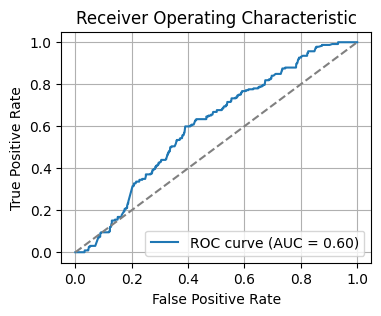

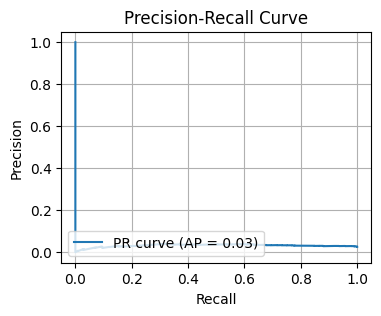

(0.95499720826354, 0.9673333333333334)

In [ ]:
test_params(n_estimators=10)

Confusion Matrix:
[[6955  785]
 [1179   81]]


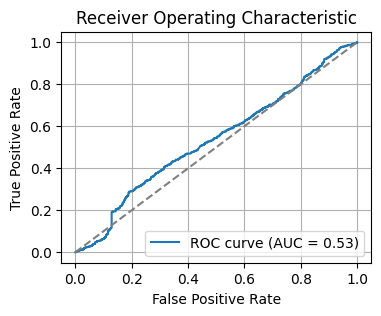

(0.8946119486320492, 0.7817777777777778)

In [ ]:
test_params(n_estimators=30)

In [ ]:
test_params(n_estimators=100)

Confusion Matrix:
[[6688 1052]
 [1064  196]]


(0.9248743718592964, 0.7648888888888888)

In [ ]:
test_params(n_estimators=240)

Confusion Matrix:
[[6545 1195]
 [1057  203]]


(0.9516471245114462, 0.7497777777777778)

In [ ]:
test_params(max_depth=2)

Confusion Matrix:
[[7250  490]
 [1173   87]]


(0.8337241764377443, 0.8152222222222222)

In [ ]:
test_params(max_depth=5)

Confusion Matrix:
[[6771  969]
 [1103  157]]


(0.9109436069235064, 0.7697777777777778)

In [ ]:
test_params(max_depth=10)

Confusion Matrix:
[[6604 1136]
 [1077  183]]


(0.9656616415410385, 0.7541111111111111)

In [ ]:
test_params(n_estimators=50, learning_rate=0.01)

Confusion Matrix:
[[7681   59]
 [1256    4]]


(0.8054159687325516, 0.8538888888888889)

In [ ]:
test_params(n_estimators=50, learning_rate=0.1)

Confusion Matrix:
[[7131  609]
 [1096  164]]


(0.874427694025684, 0.8105555555555556)

In [ ]:
test_params(n_estimators=50, learning_rate=0.3)

Confusion Matrix:
[[6790  950]
 [1097  163]]


(0.9078726968174204, 0.7725555555555556)

In [ ]:
test_params(n_estimators=50, learning_rate=0.9)

Confusion Matrix:
[[6414 1326]
 [1057  203]]


(0.9355667225013958, 0.7352222222222222)

In [ ]:
test_params(n_estimators=50, learning_rate=0.99)

Confusion Matrix:
[[6493 1247]
 [1057  203]]


(0.9419877163595757, 0.744)

In [ ]:
test_params(booster='gblinear')

Confusion Matrix:
[[7727   13]
 [1241   19]]


(0.7828866554997208, 0.8606666666666667)

## Issue: Not working at all

In [ ]:
positives = y.sum()
negatives = len(y) - positives
print(f"Positives: {positives}  |  Negatives: {negatives}  "
      f"({positives/len(y):.4%} positive)")

Positives: 7920  |  Negatives: 27900  (22.1106% positive)


Confusion Matrix:
[[8513  255]
 [ 208   24]]


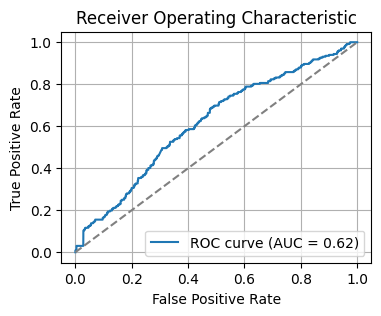

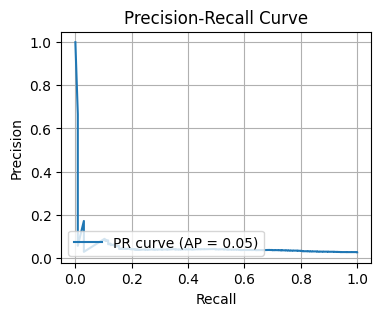

(0.9725293132328309, 0.9485555555555556)

In [ ]:
scale_pos_weight = negatives / positives


test_params(n_estimators=5000,
            max_depth=4,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            eval_metric='aucpr',
            scale_pos_weight=scale_pos_weight,
            max_delta_step=1
            )

In [ ]:
# Patient has visit -> all days are 1
fitbit_data = pd.read_csv('/content/drive/My Drive/colab_data/data_daily_w_visits.csv')

# Loop through each user group
for user_id, group in fitbit_data.groupby('fitbit_user_id'):
    if (group['visit_day'] == 1).any():
        # Set all rows for this user to 1 in the original dataframe
        fitbit_data.loc[fitbit_data['fitbit_user_id'] == user_id, 'visit_day'] = 1

In [ ]:
import pandas as pd

# Load your data
fitbit_data = pd.read_csv('/content/drive/My Drive/colab_data/data_daily_w_visits.csv')

# Sort for safety
fitbit_data = fitbit_data.sort_values(by=['fitbit_user_id', 'days'])

# Iterate by user
for user_id, group in fitbit_data.groupby('fitbit_user_id'):
    visit_days = group[group['visit_day'] == 1]['days'].values

    for visit_day in visit_days:
        # Get range from (visit_day - 14) to (visit_day + 14)
        lower = visit_day - 14
        upper = visit_day + 14

        # Create mask for the affected rows for this user
        mask = (
            (fitbit_data['fitbit_user_id'] == user_id) &
            (fitbit_data['days'] >= lower) &
            (fitbit_data['days'] <= upper)
        )

        fitbit_data.loc[mask, 'visit_day'] = 1
